In [ ]:
# https://ahnjg.tistory.com/33

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime

In [12]:
# 환경설정
plt.style.use('classic')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [4]:
# 데이터 불러오기
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True
)
csv_path, _ = os.path.splitext(zip_path)

temp = pd.read_csv(csv_path)
temp['Date Time'] = temp['Date Time'].apply(lambda x: datetime.strptime(x, '%d.%m.%Y %H:%M:%S'))
temp = temp[['Date Time', 'T (degC)']]
temp.columns = ['datetime', 'temp']

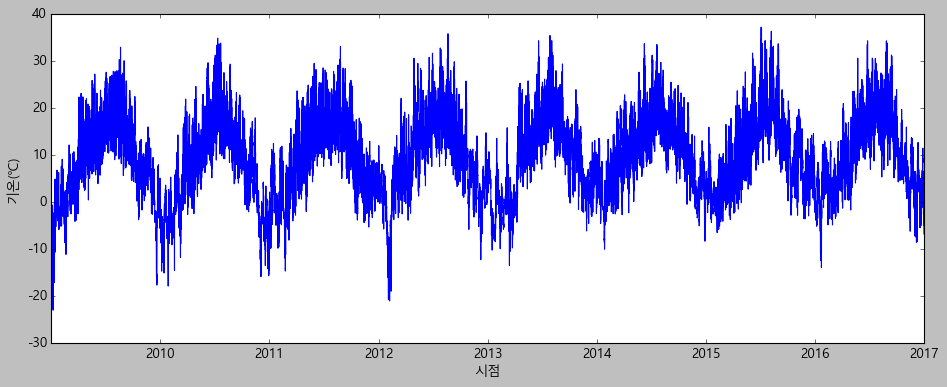

,count,mean,std,min,25%,50%,75%,max
temp,420551.0,9.450147,8.423365,-23.01,3.36,9.42,15.47,37.28


In [28]:
# 시각화
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(temp['datetime'], temp['temp'])
ax.set_xlabel('시점')
ax.set_ylabel('기온(℃)')
plt.tight_layout()
plt.show()

# 요약
temp_summary = temp.describe().T
temp_summary

#### RNN 기본 구조
* RNN은 hidden node가 방향을 가진 edge로 연결되 순환구조를 이루는 인공신경망의 한 종유임
* 순차적으로 등장하는 데이터 처리에 적합한 모델임
* sequence 길이에 관계없이 input과 output을 받아들일 수 있는 network 구조임
![RNN구조](img/rnn_structure.png)
* **녹색** 박스는 hidden state를 의미, **빨간** 박스는 input $x$를 의미함, **파란** 박스는 output $y$를 의미
* $h_t$는 $h_{t-1}$를 받아 갱신됨
* $y_t$는 $h_t$를 전달받아 갱신됨
* hidden state의 activation function는 hyperbolic tangent($tanh$)임

#### RNN 동작 예시
* character-level-model: 어떤 글자가 주어졌을 때 바로 다음 글자를 예측
* 'h', 'e', 'l', 'o': $[1,0,0,0]$, $[0,1,0,0]$, $[0,0,1,0]$, $[0,0,0,1]$
* $x_1=[1,0,0,0]$를 기반으로 $h_1=[0.3,-0.1,0.9]$ 생성 ($h_0$는 random)
* $h_1=[0.3,-0.1,0.9]$를 기반으로 $y_1=[1.0,2.2,-3.0,4.1]$ 생성
* RNN이 학습하는 parameter
 - $x_{t}$를 $h_{t}$로 보내는 $W_{xh}$
 - $h_{t-1}$를 $h_{t}$로 보내는 $W_{hh}$, $b_{h}$
 - $h_{t}$를 $y_{t}$로 보내는 $W_{hy}$, $b_{y}$
![forward](img/forward.png)

[참고자료(수식입력)](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Typesetting%20Equations.html)  
[참고자료(RNN)](https://ratsgo.github.io/natural%20language%20processing/2017/03/09/rnnlstm/)

[참고자료(RNN(2))](https://datascienceschool.net/view-notebook/1d93b9dc6c624fbaa6af2ce9290e2479/)

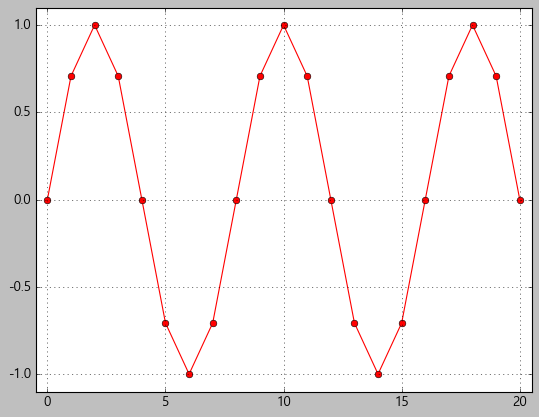

In [180]:
# 시계열 예측 문제 샘플데이터
s = np.sin(2*np.pi*0.125*np.arange(21))
plt.plot(s, 'ro-')
plt.xlim(-0.5, 20.5)
plt.ylim(-1.1, 1.1)
plt.grid()
plt.show()

* **input**: 이전 3개의 값, **target**: 바로 다음 값 (many-to-one)
* Keras 입력 데이터: (nb_samples, timesteps, input_dim)
|변수|의미|값|
|---|:---|:---|
|nb_sample|자료의 수|18개(길이-순서열길이)|
|timesteps|순서열의 길이|이전 3개의 값을 사용하므로 3|
|input_dim|X vector의 길이|단일 시계열이므로 1|

In [172]:
from scipy.linalg import toeplitz
# Toeplitz Matrix: 대각선 위의 성분길이 같은 Square matrix
# np.fliplr, np.flipud: 2차원 matrix를 좌우, 위아래로 반전

In [182]:
S = np.fliplr(toeplitz(np.r_[s[-1], np.zeros(s.shape[0]-3)], s[::-1]))
X_train = S[:-1, :3][:, :, np.newaxis]
y_train = S[:-1, 3]

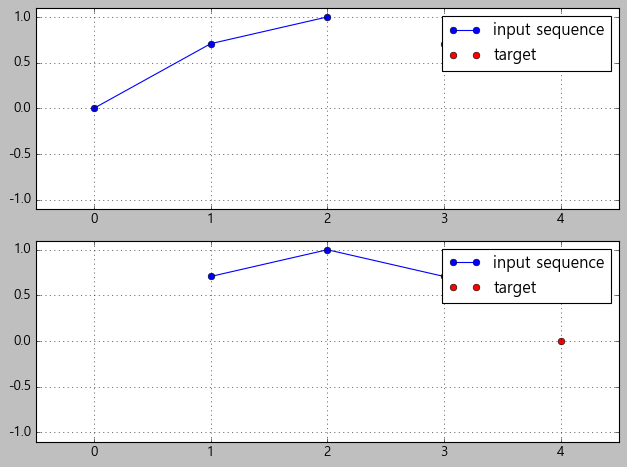

In [186]:
plt.subplot(211)
plt.plot([0, 1, 2], X_train[0].flatten(), 'bo-', label='input sequence')
plt.plot([3], y_train[0], 'ro', label='target')
plt.xlim(-0.5, 4.5)
plt.ylim(-1.1, 1.1)
plt.legend()
plt.grid()

plt.subplot(212)
plt.plot([1, 2, 3], X_train[1].flatten(), 'bo-', label='input sequence')
plt.plot([4], y_train[1], 'ro', label='target')
plt.xlim(-0.5, 4.5)
plt.ylim(-1.1, 1.1)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

#### Keras의 SimpleRNN class
1. `Sequential` class의 object인 model 생성
2. `add` method로 다양한 layer 추가
3. `compile` method로 objective function 및 optimizer를 지정
4. `fit` method로 weight 계산

* **Loss** : mean-squared-error(mse)  
* **Optimizer** : stochastic gradient descent(sgd)

In [207]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

np.random.seed(0)
model = Sequential()
model.add(SimpleRNN(10, input_shape=(3,1)))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='sgd')

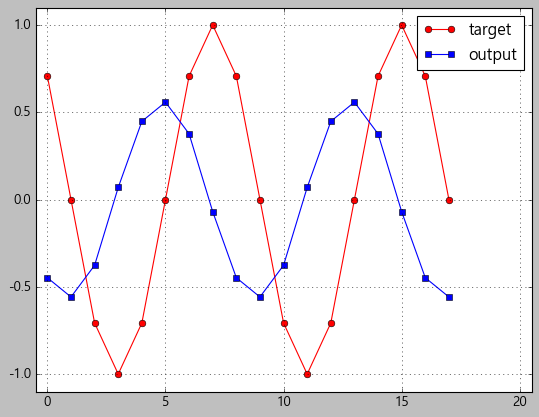

In [208]:
plt.plot(y_train, 'ro-', label="target")
plt.plot(model.predict(X_train[:, :, :]).flatten(), 'bs-', label="output")
plt.xlim(-0.5, 20.5)
plt.ylim(-1.1, 1.1)
plt.legend()
plt.grid()
plt.show()

In [209]:
history = model.fit(X_train, y_train, epochs=100, verbose=0)

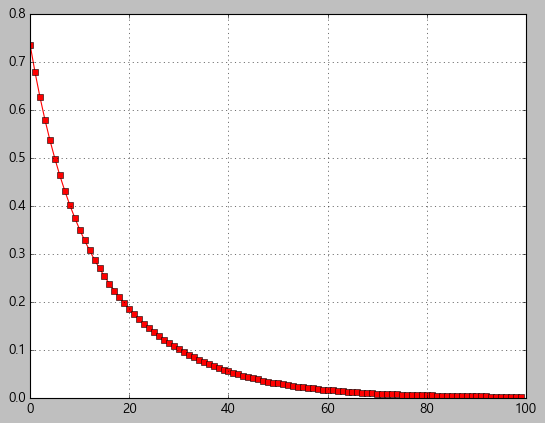

In [218]:
plt.plot(history.history['loss'], 'rs-')
plt.grid()
plt.show()

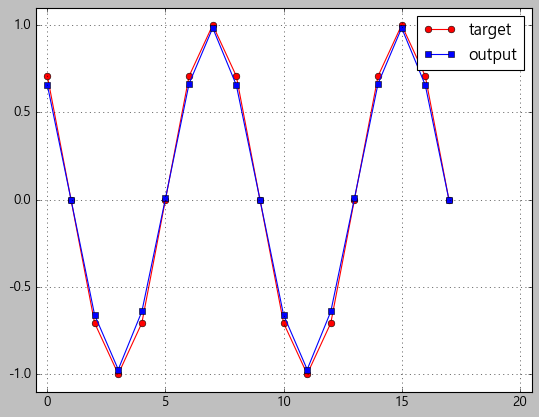

In [219]:
plt.plot(y_train, 'ro-', label="target")
plt.plot(model.predict(X_train[:, :, :]).flatten(), 'bs-', label="output")
plt.xlim(-0.5, 20.5)
plt.ylim(-1.1, 1.1)
plt.legend()
plt.grid()
plt.show()

In [225]:
model = Sequential()
model.add(Dense(6, kernel_initializer='uniform', activation='relu', input_dim=3))
model.add(Dense(4, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
model.compile(loss='mse', optimizer='sgd')

In [235]:
X = np.random.normal(size=(1000,3))
y = np.random.normal(size=1000)

In [350]:
history = model.fit(X, y, epochs=200, verbose=0, batch_size=None)

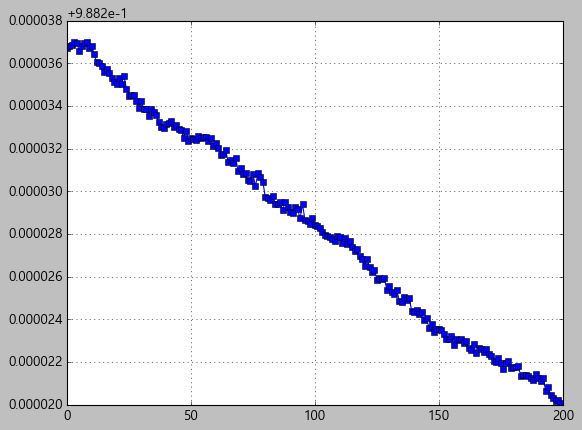

In [354]:
plt.plot(history.history['loss'], '-s')
plt.grid()
plt.show()

* Epoch : 전체 sample 데이터를 1바퀴 돌며 학습 = 1 Epoch
* Step : Weight Bias를 1회 업데이트하는 것 = 1 Step
* Batch Size : 1 Step에서 사용한 데이터의 수
* Batch Size=100, Step=5 ☞ 데이터 수 : 약 500개

$s=\frac{n\times e}{b}$
 - n=num of sample
 - e=epochs
 - b=batch size
 - s=steps  